In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload # reloads modules
# %aimport # lists what it will/won't reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from utils import *

### Test multiple classification methods with the original data

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Clearly feature engineering isn't really an option here since we are dealing with SVD modes.


| Columns       | Description |
|:------------- |:-------------|
| amount        | amount of transaction in cents|
| time          | time of transaction in seconds|
| class         | boolean fraudulent/legitimate-->1/0|
| V\*           | SVD features (US in svd USV')|

In [3]:
data.shape

(284807, 31)

In [4]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

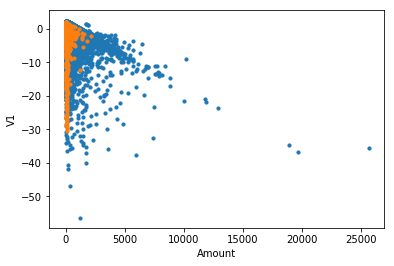

In [5]:
ax = plot_features('Amount','V1',data)
plt.show()

In [6]:
cols = list(data.columns)[1:] # removes time

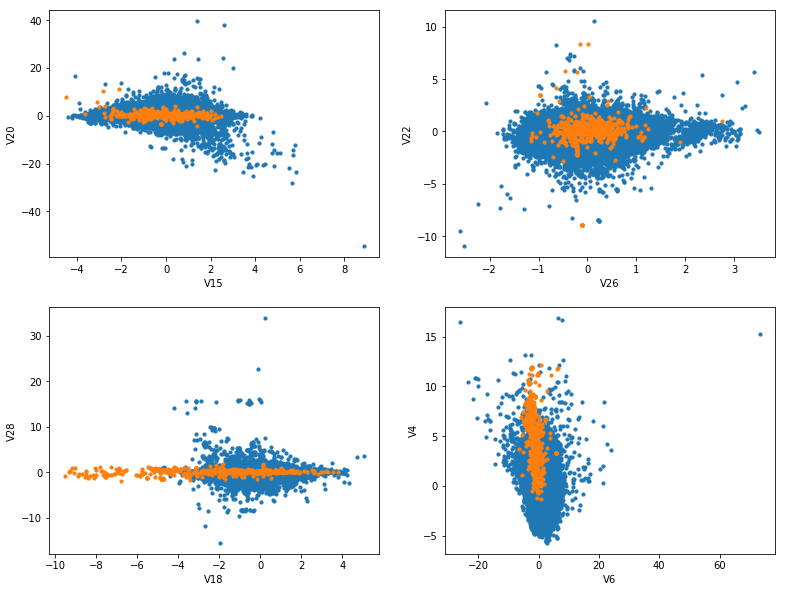

In [7]:
tile_random_features(cols[0:-1], data) # don't plot 'Class'
# list(np.random.choice(col_names, 2, replace=False)) + ['squat']

Data often doesn't look very Gaussian in some dimensions, let's see how gaussian approaches look..

KNN looks like a much more promising approach, granted we alter the cost function to predict the minority class when there are verrry few within the nearest k (maybe 1..). This sounds like a recipe for overfitting however. Perhaps to match this with SMOTE would make for good results.

SVM, or really any linear classifier, looks like it would perform poorly.

#### Prep data

In [8]:
train, test = train_test_split(data, test_size=0.2)

print 'Sanity check:'
print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

Sanity check:
% of fraud cases in original, train, and test sets:
0.00172748563062
0.00175119050232
0.0016326673923


In [63]:
# use a subset of the 28 features in the complete data set to reduce computation
n_dims = 15
cols_reduced = cols[0:n_dims] + cols[-2:]
# use same train/ test to compare dim red to full data
train, test = train_test_split(data, test_size=0.2)

class empty(): pass # TODO don't
reduced_data = empty()
reduced_data.X, reduced_data.y = [df.values for df in split_class(data[cols_reduced])]
reduced_data.x_train, reduced_data.y_train = [df.values for df in split_class(train[cols_reduced])]
reduced_data.x_test, reduced_data.y_test = [df.values for df in split_class(test[cols_reduced])]
# full set, just in case
X, y = [df.values for df in split_class(data)]

### Implement classification methods

Find the best classifiers for this dataset. Here is where we test any potential algorithm improvements to the class imbalance.

In [11]:
avg_model_scores = {}

#### Gaussian Methods
It seems pretty absurd to use LDA here given that each class must share the same covariance matrix. Based on above plots this seems silly, and basically completely determined by the majority class. Let's try quadratic discriminant analysis instead, plus Naive Bayes. Naive Bayes is like QDA with diagonal covariance matrices, so more restricted

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

Is there a cost to reducing number of features? Not really.

In [35]:
# name = "QDA"
# print name
# test_model(QuadraticDiscriminantAnalysis(), X, y);

# name = "Naive Bayes"
# print ''
# print name
# test_model(GaussianNB(), X, y);

QDA
Precision: 	0.06
Recall: 	0.87
F1: 		0.11
Geometric mean: 0.92

Naive Bayes
Precision: 	0.14
Recall: 	0.66
F1: 		0.23
Geometric mean: 0.80


In [36]:
name = "qda"
print "QDA (n_dims={})".format(n_dims)
avg_model_scores[name] = test_model(QuadraticDiscriminantAnalysis(), reduced_data.X, reduced_data.y)

name = "naive_bayes"
print ''
print "Naive Bayes (n_dims={})".format(n_dims)
avg_model_scores[name] = test_model(GaussianNB(), reduced_data.X, reduced_data.y)

QDA (n_dims=15)
Precision: 	0.06
Recall: 	0.87
F1: 		0.11
Geometric mean: 0.92

Naive Bayes (n_dims=15)
Precision: 	0.08
Recall: 	0.82
F1: 		0.14
Geometric mean: 0.90


Surprisingly QDA actually did pretty well.

#### Trees / Random Forests

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

name = "tree"
print name
avg_model_scores[name] = test_model(DecisionTreeClassifier(), reduced_data.X, reduced_data.y, cv=3)

name = 'rf_gini'
print ''
print name
avg_model_scores[name] = test_model(RandomForestClassifier(n_estimators=10), reduced_data.X, reduced_data.y, cv=3)

# entropy should work better for imbalanced classes
name = 'rf_entropy'
print ''
print name
avg_model_scores[name] = test_model(RandomForestClassifier(criterion='entropy'), reduced_data.X, reduced_data.y, cv=3)

tree
Precision: 	0.55
Recall: 	0.75
F1: 		0.62
Geometric mean: 0.87

rf_gini
Precision: 	0.87
Recall: 	0.73
F1: 		0.78
Geometric mean: 0.85

rf_entropy
Precision: 	0.88
Recall: 	0.75
F1: 		0.80
Geometric mean: 0.86


Try the class weight param

In [37]:
name = 'tree_balanced'
print ''
print name
test_model(RandomForestClassifier(criterion='gini', class_weight='balanced'), reduced_data.X, reduced_data.y, cv=3)
print ''
test_model(RandomForestClassifier(criterion='entropy', class_weight='balanced'), reduced_data.X, reduced_data.y, cv=3);


tree_balanced
Precision: 	0.88
Recall: 	0.68
F1: 		0.75
Geometric mean: 0.82

Precision: 	0.89
Recall: 	0.70
F1: 		0.77
Geometric mean: 0.84


#### KNN

Scikit didn't allow me to tune the built in classifier in the way I wanted so I made my own, built on scikit's NearestNeighbors algorithms. Essentially instead of each of the N neighbors getting a equal vote for which class the test point should be, I wanted the minorty class to have a more impactful vote. In the most extreme case this means that if _any_ of the neighbors are members of the minority class then we assign the minority class to the test point as well.

Note: KNN is known to not perform well on high dimensional data

In [15]:
from WeightedKNN import WeightedKNN

N = 5

# print "Weighted K-nearest neighbors"

# weight = 1 # weight 1 means majority vote
# print "Boring majority vote condition"
# wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1)
# # print_metrics(reduced_data.test_y, wknn.fit(reduced_data.train_x, reduced_data.train_y).predict(reduced_data.test_x))
# avg_model_scores[name] = test_model(wknn, X, y, cv=3)

# weight = 3
# print "Unequal voting: class 1 gets {} votes".format(weight)
# wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
# # print_metrics(test_y, wknn.fit(train_x, train_y).predict(test_x))
# avg_scores,_ = test_model(wknn, reduced_data.X, reduced_data.y, cv=3)

# weight = N # for all weight values > (N+1)/2 you get the one vote counts case
# print "Vigilant condition: is fraud if _any_ neightbors are"
# wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
# # print_metrics(test_y, wknn.fit(train_x, train_y).predict(test_x))
# avg_scores,_ = test_model(wknn, reduced_data.X, reduced_data.y, cv=3)

Conclusion: Even in the 'vigilant' case this method doesn't do a great job on recall.

#### Logistic Regression

You can also add a L1 or L2 regularization term. We don't have any reason to think that promoting sparisity on the input would be helpful here but we will test it anyway. Sklearn support class weighting out of the box, but we want to see baseline performance to start.

In [31]:
from sklearn.linear_model import LogisticRegression

name = 'logit'
print name
avg_model_scores[name] = test_model(LogisticRegression(), reduced_data.X, reduced_data.y)

name = 'logit_bal'
print ''
print name
# avg_model_scores[name] = 
test_model(LogisticRegression(class_weight='balanced'), 
           reduced_data.X, reduced_data.y);

logit
Precision: 	0.86
Recall: 	0.61
F1: 		0.69
Geometric mean: 0.77

logit_bal
Precision: 	0.06
Recall: 	0.88
F1: 		0.10
Geometric mean: 0.93


Hey, pretty damn good when balanced! Kinda of meh otherwise. 
Let's use GridSearch to find the best combination of hyperparameters

In [17]:
# from sklearn.model_selection import GridSearchCV
# param_grid = [
#   {'penalty':['l1','l2'], 'C': [1.0/1000, 1.0/100, 1./10, 1, 10], 'class_weight': ['balanced']}
#  ]
# gs = GridSearchCV(LogisticRegression(), param_grid, scoring='recall')
# gs.fit(train_x, train_y)

In [18]:
# print 'Recall Scores'
# means = gs.cv_results_['mean_test_score']
# stds = gs.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, gs.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
    
# print ''
# print "Best parameters"
# print gs.best_params_
# print ''

# print_metrics(test_y, gs.predict(test_x))

Not much different than the non-regularized version... so still good

#### SVC

The right option here is to weight the classes, and sklearn supports that, but again we want to see baseline performance to start. Also may be nice to try some kernels, since the data did not appear to be linearly separable, however the run time is quite large. 

In [29]:
from sklearn.svm import SVC, LinearSVC

name = 'svc'
print name
avg_model_scores[name] = test_model(LinearSVC(C=1.0, dual=False), 
                                    reduced_data.X, reduced_data.y)

name = 'svc_weighted'
print name
# avg_model_scores[name] = 
test_model(LinearSVC(C=1.0, class_weight={0:1,1:100}, dual=False), 
                                    reduced_data.X, reduced_data.y);

svc
Precision: 	0.92
Recall: 	0.55
F1: 		0.66
Geometric mean: 0.73
svc_weighted
Precision: 	0.37
Recall: 	0.86
F1: 		0.50
Geometric mean: 0.92


### Compare models

In [38]:
means = {}
# metrics = ['precision', 'recall', 'f1', 'geometric']
metrics = ['accuracy', 'recall', 'geometric', 'f1']

for k in avg_model_scores.keys():
    means[k] = {}
    for metric in metrics:
        means[k][metric] = avg_model_scores[k]['test_' + metric].mean()

models = means.keys()
df = pd.DataFrame(index=models, columns=metrics, dtype=float)

for model in models:
    df.loc[model] = [means[model][m] for m in metrics]


df

,accuracy,recall,geometric,f1
logit,0.999108,0.607174,0.772840,0.691942
qda,0.975173,0.865760,0.918705,0.108590
tree,0.998213,0.752033,0.866446,0.618847
svc,0.999087,0.552216,0.734056,0.662662
rf_gini,0.999308,0.725610,0.851078,0.784099
rf_entropy,0.999357,0.745935,0.863100,0.801535
naive_bayes,0.982244,0.818924,0.896147,0.137677


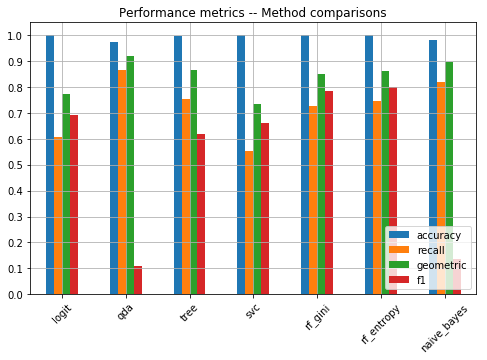

In [39]:
# df.plot.bar(figsize=(8,5),rot=0)
# plt.title('Performance metrics on raw data')
# plt.legend(loc='center right')
# plt.show()

bar_plot(df, subtitle='Method comparisons', legend_loc='lower right')
# bar_plot(df.drop(['tree_entropy']), subtitle='Method comparisons', legend_loc='lower right')

Clearly f1 is more sensitive to precision and geometric mean more sensitive to recall. We will go with the geometric mean as the more important measure bit you can see that NB and QDA both have a noticible dip in the accuracy. This is actually an issue for the fraud detection use case since we would be dealing with hundreds of thousands of transactions a day perhaps. The very low f1 score here is a warning sign that we have to consider. We should not use these methods.

### Baseline ROC and PR curves

In [46]:
qda    = QuadraticDiscriminantAnalysis().fit(reduced_data.train_x, reduced_data.train_y)
svc    = LinearSVC(C=1.0, dual=False).fit(reduced_data.X, reduced_data.y)
logit  = LogisticRegression().fit(reduced_data.train_x, reduced_data.train_y)
nb     = GaussianNB().fit(reduced_data.train_x, reduced_data.train_y)
forest = RandomForestClassifier(n_estimators=10, criterion='entropy').fit(reduced_data.train_x, reduced_data.train_y)

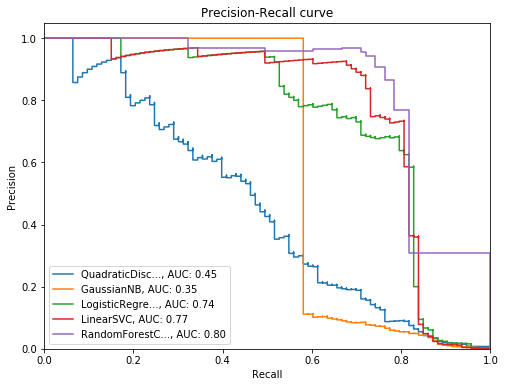

In [47]:
plt.figure(figsize=(8,6))
ax = plt.subplot(111)

plot_pr(qda,   reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(nb,    reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(logit, reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(svc,  reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(forest,  reduced_data.test_x, reduced_data.test_y, ax=ax)
plt.show()

A low precision is acceptable, but not crazy low. I think this again shows the weakness of the gaussian methods. The AUC metric clearly shows we should use the others...

#### Let's move forward with the 3 best (and most common) classifiers: logistic regression, random forest, and SVC

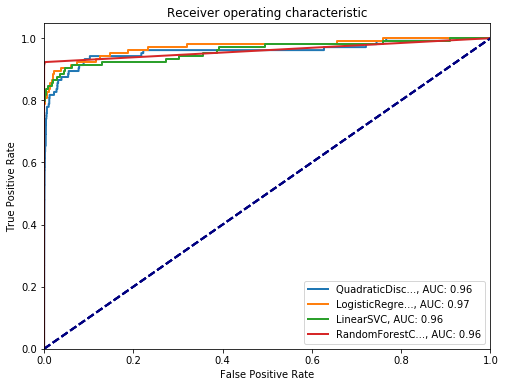

In [67]:
models = [qda,logit,svc,forest]
l = [truncate_dotdot(get_class_name(m)) for m in models]
plot_many_roc(models, l, reduced_data.x_test, reduced_data.y_test)

ROC/AUROC may still be useful, since we still want to maximize the true positive rate (TPR) and minimize the false positive rate (FPR).